In [1]:
from viresclient import set_token
from viresclient import SwarmRequest
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.animation as animation

from scipy import signal

from scipy import constants
import aacgmv2
import asilib
import asilib.asi
mu0 = constants.mu_0
from numpy.typing import NDArray
import mplcyberpunk
#plt.style.use("cyberpunk")

In [2]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=25):
    return butter(order, cutoff, fs=fs, btype="low", analog=False)


def butter_lowpass_filter(data, cutoff, fs, order=25):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [3]:
def sinc_interpolation(x: NDArray, s: NDArray, u: NDArray) -> NDArray:
    """Whittaker–Shannon or sinc or bandlimited interpolation.
    Args:
        x (NDArray): signal to be interpolated, can be 1D or 2D
        s (NDArray): time points of x (*s* for *samples*)
        u (NDArray): time points of y (*u* for *upsampled*)
    Returns:
        NDArray: interpolated signal at time points *u*
    Reference:
        This code is based on https://gist.github.com/endolith/1297227
        and the comments therein.
    TODO:
        * implement FFT based interpolation for speed up
    """
    sinc_ = np.sinc((u - s[:, None]) / (s[1] - s[0]))

    return np.dot(x, sinc_)

In [4]:
set_token(
    "https://vires.services/ows",
    set_default=True,
    token="kmxv5mTTyYwzw4kQ9lsCkGfQHtjjJRVZ",
)  # key


Token saved for https://vires.services/ows


In [5]:
def numpy_conditioning(array):
    print(len(array))
    array_returned = np.zeros((len(array), 3))
    for i in range(len(array)):
        for j in range(3):
            array_returned[i] = array[i]
    return array_returned

In [6]:
base = datetime(2021,9, 24, 3, 46)
date_list_B = [base + timedelta(seconds=x) for x in range(132)]

In [7]:
def moving_average(a,length): #https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    n = int(len(a)*length/(date_list_B[-1]-date_list_B[0]).total_seconds())  # gives length second averaging
    y_padded = np.pad(a, (n//2, n-1-n//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((n,))/n, mode='valid')
    return y_smooth

In [8]:
Magnetic_products = "SW_OPER_MAGA_HR_1B"

request = SwarmRequest()
request.set_collection(Magnetic_products)
request.set_products(
    measurements=["B_NEC", "Flags_B"],
    models=["CHAOS"],
    residuals=False,  # grabs residual from chaos
)
data = request.get_between(
    start_time=date_list_B[0] - timedelta(seconds=5),
    end_time=date_list_B[-1] + timedelta(seconds=5),
    asynchronous=False,
)
# changes data into a dataframe format, which is easy to use
df_b = data.as_dataframe()
time_b_B=df_b.index.to_pydatetime()
B_NEC = numpy_conditioning(df_b["B_NEC"].to_numpy()) * 10 ** (-9)
B_CHAOS = numpy_conditioning(df_b["B_NEC_CHAOS"].to_numpy()) * 10 ** (-9)
B_RES_B = B_NEC - B_CHAOS
Electric_products = "SW_EXPT_EFIA_TCT16"

request = SwarmRequest()
request.set_collection(Electric_products)
request.set_products(
    measurements=[
        "Ehx",
        "Ehy",
        "Ehz",
        "VsatN",
        "VsatE",
        "VsatC",
        "Calibration_flags",
        "Quality_flags",
    ],
)
data = request.get_between(
    start_time=date_list_B[0] - timedelta(seconds=5),
    end_time=date_list_B[-1] + timedelta(seconds=5),
    asynchronous=False,
)
# changes data into a dataframe format, which is easy to use
df_E = data.as_dataframe()
print(df_E)
time_e_B=df_E.index.to_pydatetime()
# E derived from the horizontal sensor
E_data_numpy = df_E[["Ehx", "Ehy", "Ehz"]].to_numpy() * 0.001
V_data_numpy = df_E[["VsatN", "VsatE", "VsatC"]].to_numpy()
E_data = numpy_conditioning(E_data_numpy)
Velocity = numpy_conditioning(E_data_numpy)
VelocitySum = np.abs(Velocity).sum(axis=1)

Velocity_Unit = Velocity / VelocitySum[:, np.newaxis]
ElectricNEC_B = np.multiply(Velocity_Unit, E_data)
B_RES_resample_B = np.empty((len(ElectricNEC_B), 3))
B_RES_sinc_B = np.empty((len(ElectricNEC_B), 3))
lat_satellite_not_footprint = df_b["Latitude"].to_numpy()
lon_satellite_not_footprint = df_b["Longitude"].to_numpy()
altitude = df_b["Radius"].to_numpy() / 1000 - 6378.1370

# conjunction_obj = asilib.Conjunction(asi, (df_b.to_numpy(), np.array([lat_satellite_not_footprint, lon_satellite_not_footprint, altitude]).T))

# Converts altitude to assumed auroral height
helper = np.vectorize(lambda x: x.timestamp())
# foot_print_coord=conjunction_obj.lla_footprint(alt=110)
lat_B,long,alt=aacgmv2.convert_latlon_arr(lat_satellite_not_footprint,lon_satellite_not_footprint,altitude,base,"G2A")
print(time_e_B)


Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.586MB)

7050
7050


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.139MB)

                                Latitude      VsatC Spacecraft     Radius  \
Timestamp                                                                   
2021-09-24 03:45:55.006750208  52.092327 -13.312078          A  6799890.5   
2021-09-24 03:45:55.068749824  52.096313 -13.311998          A  6799889.5   
2021-09-24 03:45:55.131750144  52.100368 -13.311917          A  6799889.0   
2021-09-24 03:45:55.193750016  52.104355 -13.311837          A  6799888.5   
2021-09-24 03:45:55.256750080  52.108410 -13.311756          A  6799887.5   
...                                  ...        ...        ...        ...   
2021-09-24 03:48:15.693750016  61.137226 -12.227398          A  6798623.0   
2021-09-24 03:48:15.756750080  61.141270 -12.226554          A  6798622.5   
2021-09-24 03:48:15.818749952  61.145252 -12.225722          A  6798622.0   
2021-09-24 03:48:15.881750016  61.149300 -12.224878          A  6798621.5   
2021-09-24 03:48:15.943749888  61.153282 -12.224048          A  6798621.0   

In [9]:
for i in range(len(df_E['Quality_flags'])):
    print(df_E['Quality_flags'][i])

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


In [10]:
for i in range(len(df_E['Calibration_flags'])):
    print(df_E['Calibration_flags'][i])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

In [11]:
#intialize filter
b,a = butter_lowpass(7.5,50, 20) #https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

In [12]:
B_not_averaged=np.array(B_RES_B[:,1])
for i in range(3):
    ElectricNEC_B[:, i] = ElectricNEC_B[:, i] - moving_average(ElectricNEC_B[:, i], 20)
for i in range(3):
    B_RES_B[:, i] = B_RES_B[:, i] - moving_average(B_RES_B[:, i], 20)
for i in range(3):
    B_RES_B[:, i] = signal.filtfilt(a=a,b=b,x=B_RES_B[:, i])
for i in range(3):
    B_RES_resample_B[:, i] = signal.resample(B_RES_B[:, i], len(ElectricNEC_B[:, 0]))
for i in range(3):
    B_RES_sinc_B[:, i] = sinc_interpolation(B_RES_B[:, i], helper(time_b_B), helper(time_e_B))

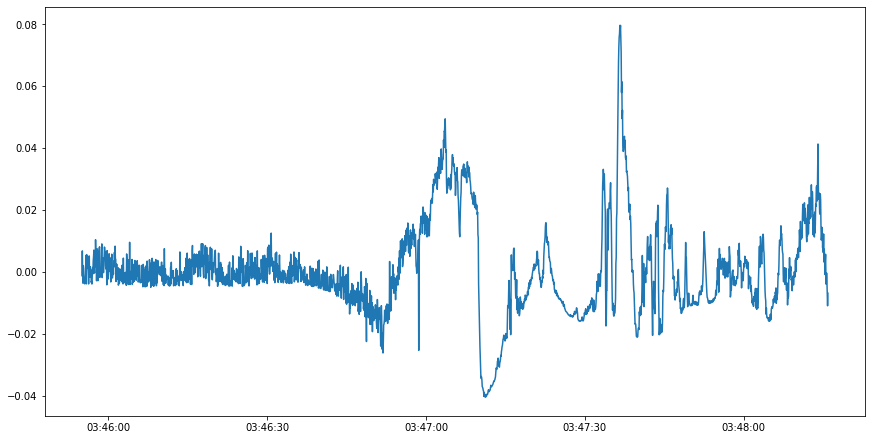

In [13]:
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
plt.plot(time_e_B, ElectricNEC_B[:, 0])

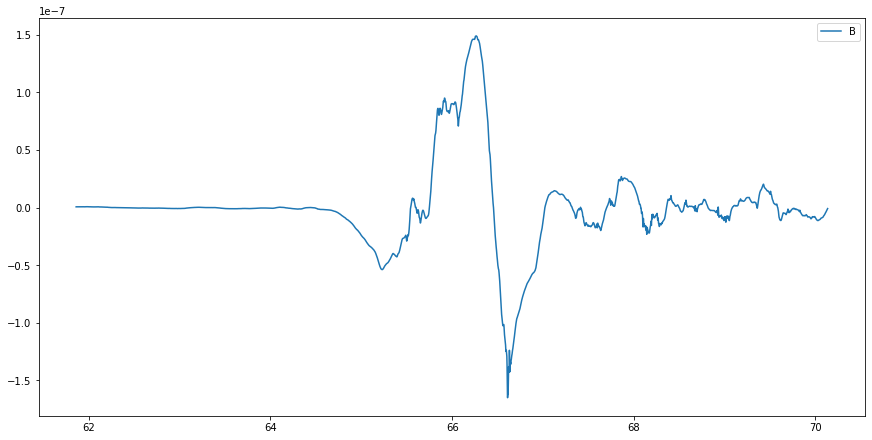

In [14]:
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
plt.plot(lat_B,B_RES_B[:,1], label='B')
plt.legend()

In [15]:
for i in range(len(df_E['Quality_flags'])):
    print(df_E['Quality_flags'][i])

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


In [16]:
for i in range(len(df_E['Calibration_flags'])):
    print(df_E['Calibration_flags'][i])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0.8018485552716772
22871878.710761264


(18894.157349537036, 18894.15798611111)

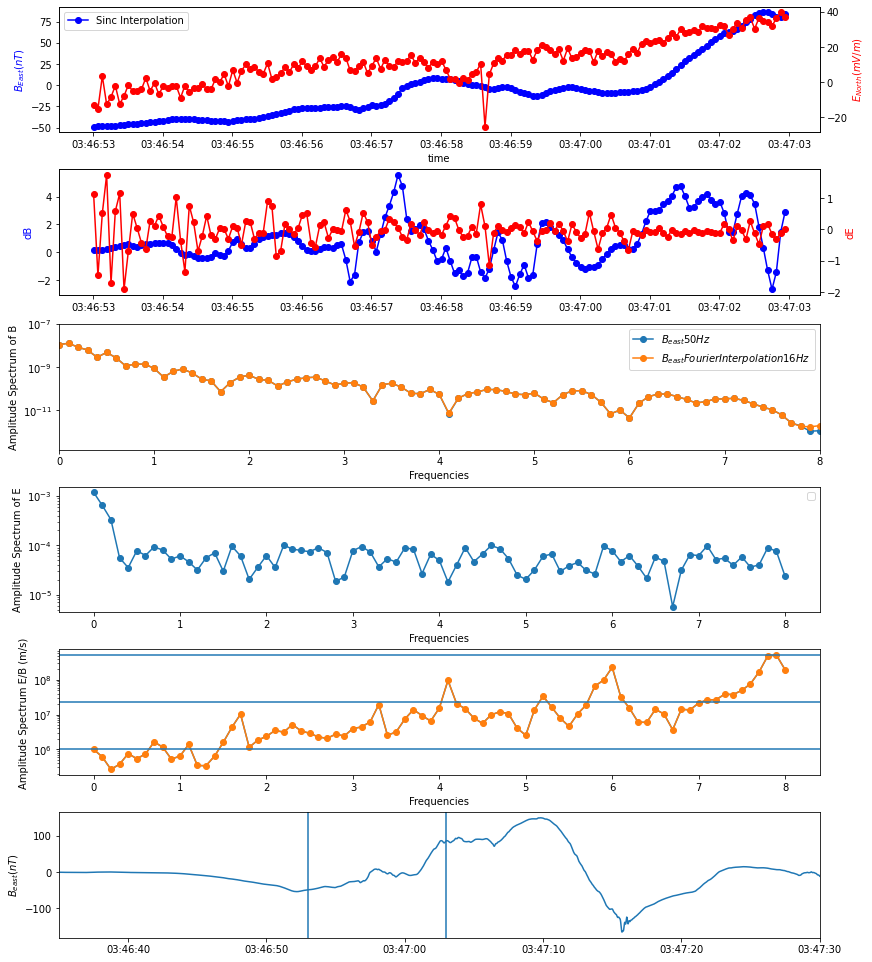

In [17]:
from scipy import interpolate

fig = plt.figure(figsize=(12, 15), constrained_layout=True)


gs = fig.add_gridspec(7, 1)


ax1 = fig.add_subplot(gs[0, 0])

ax5 = fig.add_subplot(gs[1, 0])

ax7 = fig.add_subplot(gs[2, 0])

ax9 = fig.add_subplot(gs[3, 0])

ax11= fig.add_subplot(gs[4, 0])

ax13= fig.add_subplot(gs[5, 0])
ax = [ax7, ax9, ax1, ax11, ax13, ax5]


sigma_p = 3


lat_list = lat_B


time_e = time_e_B


time_b = time_b_B


B_RES = B_RES_B


datelist = date_list_B


ElectricNEC = ElectricNEC_B


B_RES_resample = B_RES_resample_B

B_RES_sinc = B_RES_sinc_B


number = "B"



time_range = (datetime(2021,9,24,3,46,53), datetime(2021,9,24,3,47,3))

index_min_e = []

index_min_b = []

index_max_e = []

index_max_b = []

for k in range(len(time_e)):
    index_min_e.append(
        np.abs((time_range[0] - time_e[k]).total_seconds() / 60.0)
    )
    index_max_e.append(
        np.abs((time_range[1] - time_e[k]).total_seconds() / 60.0)
    )

for k in range(len(time_b)):

    index_min_b.append(
        np.abs((time_range[0] - time_b[k]).total_seconds() / 60.0)
    )
    index_max_b.append(
        np.abs((time_range[1] - time_b[k]).total_seconds() / 60.0)
    )

index_min_val_e = np.argmin(index_min_e)

index_min_val_b = np.argmin(index_min_b)

index_max_val_e = np.argmin(index_max_e)

index_max_val_b = np.argmin(index_max_b)

frequencies_50, powerspec_50 = signal.periodogram(
B_RES[range(index_min_val_b, index_max_val_b), 1],
50,
window="hann",detrend=False , scaling='spectrum'
)

ax[0].plot(
    frequencies_50, np.sqrt(powerspec_50),'-o', label=r"$B_{east} 50Hz$", 
)

frequencies_resample, powerspec_resample = signal.periodogram(
B_RES_resample[range(index_min_val_e, index_max_val_e), 1],
16,  window='hann',detrend=False , scaling='spectrum'
)
ax[0].plot(
    frequencies_resample, np.sqrt(powerspec_resample),'-o', label=r"$B_{east} Fourier Interpolation 16Hz$"
)

frequencies_B_sinc, powerspec_B_sinc = signal.periodogram(
    B_RES_sinc[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)

#ax[0].plot(frequencies_B_sinc, np.sqrt(powerspec_B_sinc), '-o', label=r"$B_{east} 16 sincHz$")

ax[0].set_xlim(0, 8)



ax[0].legend()

ax[0].set_ylabel("Amplitude Spectrum of B")

ax[0].set_xlabel("Frequencies")
ax[0].set_yscale("log")
ax[0].set_ylim(1.5e-13, 1e-7)

frequencies_E, powerspec_E = signal.periodogram(
    ElectricNEC[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)
ax[1].plot(
    frequencies_E, np.sqrt(powerspec_E), '-o', 
)

ax[1].set_ylabel("Amplitude Spectrum of E")

ax[1].set_xlabel("Frequencies")

ax[1].legend()
ax[1].set_yscale("log")

"""
ax[2].scatter(
    time_e[range(index_min_val_e, index_max_val_e)],
    B_RES_resample[range(index_min_val_e, index_max_val_e), 1]*1e9,
    label="scipy",
)
"""
ax[2].plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    B_RES_sinc[range(index_min_val_e, index_max_val_e), 1]*1e9, "-o",
    label="Sinc Interpolation", color='blue'
)

ax[2].set_ylabel("$B_{East} (nT)$", color='blue')

ax[2].set_xlabel("time")



ax[2].legend()

ax22=ax[2].twinx()
ax22.plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    ElectricNEC[range(index_min_val_e, index_max_val_e), 0]*1e3,
    "-o", color='red', 
)
ax22.set_ylabel("$E_{North} (mV/m)$", color='red')



frequencies_per_E, powerspec_per_E = signal.periodogram(
    ElectricNEC[range(index_min_val_e, index_max_val_e), 0],
    16,
    window="hann",detrend=False , scaling='spectrum'
)
frequencies_per_B_scipy, powerspec_per_B_scipy = signal.periodogram(
    B_RES_resample[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)
ax[3].plot(
    frequencies_per_B_scipy,
    np.sqrt(powerspec_per_E/powerspec_per_B_scipy),
    label="E_N/B_E resample",
)
frequencies_per_sinc, powerspec_per_B_sinc = signal.periodogram(
    B_RES_sinc[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)

ax[3].plot(frequencies_per_sinc, np.sqrt(powerspec_per_E/powerspec_per_B_scipy),'-o', label="E_N/B_E Fourier Transform")
ax[3].axhline(y=np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0])
ax[3].axhline(y=np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))
ax[3].set_yscale("log")
#ax[3].set_ylim(1e3, 1e9)

#ax[3].axhline(y=(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))**2*np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]*mu0)

ax[3].axhline(y=(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))**2* 1/(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]*mu0)*mu0)


ax[3].set_ylabel("Amplitude Spectrum E/B (m/s)")

ax[3].set_xlabel("Frequencies")
##ax[4].set_yscale("symlog")
ax[4].plot(time_b, B_RES[:,1]*1e9)
ax[4].axvline(time_range[0])
ax[4].axvline(time_range[1])
ax[4].set_ylabel(r"$B_{east} (nT)$")

ax[5].plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    np.gradient(B_RES_sinc[range(index_min_val_e, index_max_val_e), 1]*1e9),  "-o",
    label="Sinc func", color='blue'
)
ax[5].set_ylabel("dB", color='blue')
ax5=ax[5].twinx()
ax5.plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    np.gradient(ElectricNEC[range(index_min_val_e, index_max_val_e), 1]*1e3), "-o",
    label="Electric field", color='red'
)
ax5.set_ylabel("dE", color='red')
print(1/(1.256e-6*np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]))
print(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))

ax[4].set_xlim((datetime(2021,9,24,3,46,35), datetime(2021,9,24,3,47,30)))

2.65060223433165
3183877.3019470633


(18894.157349537036, 18894.15798611111)

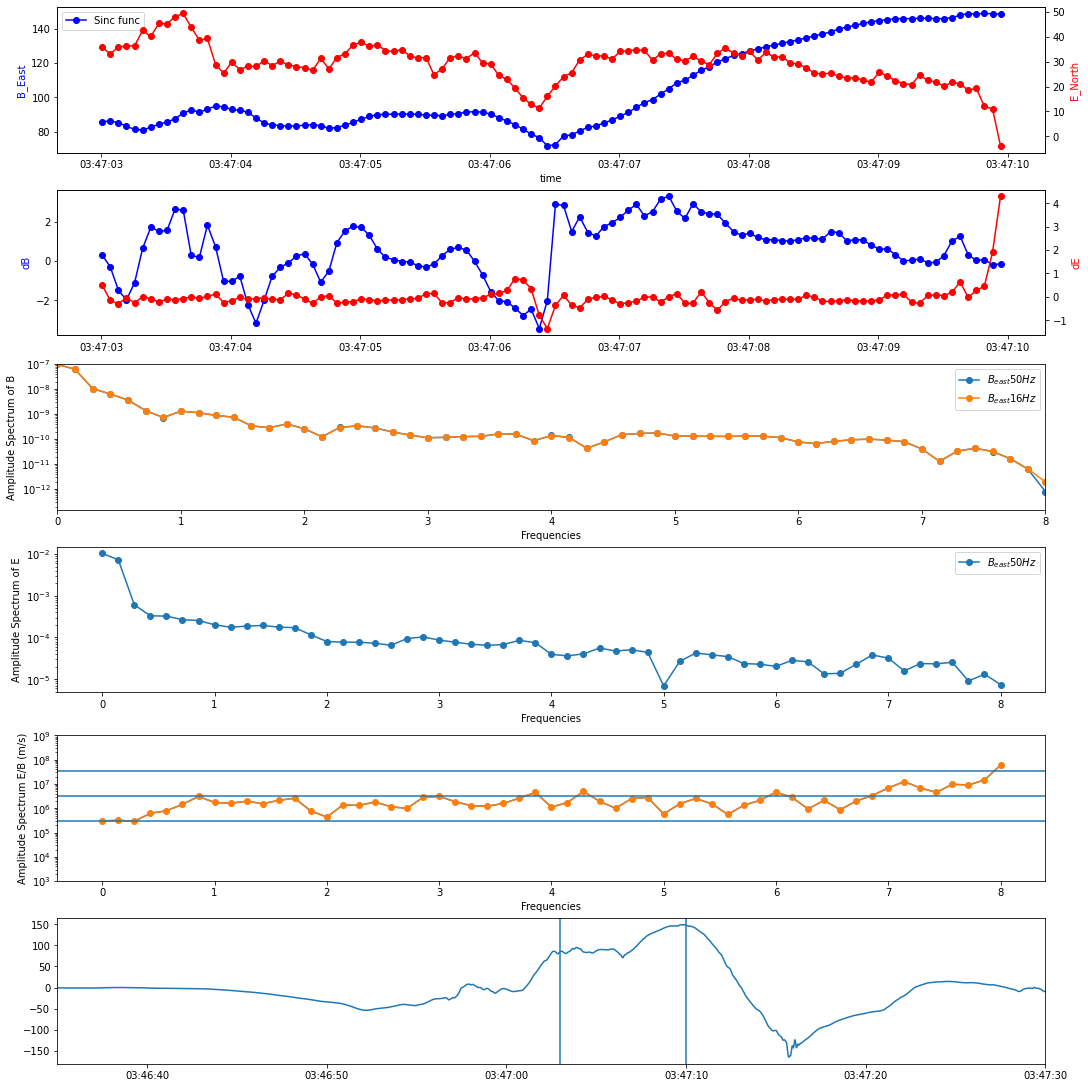

In [18]:
from scipy import interpolate

fig = plt.figure(figsize=(15, 15), constrained_layout=True)


gs = fig.add_gridspec(6, 1)


ax1 = fig.add_subplot(gs[0, 0])

ax5 = fig.add_subplot(gs[1, 0])

ax7 = fig.add_subplot(gs[2, 0])

ax9 = fig.add_subplot(gs[3, 0])

ax11= fig.add_subplot(gs[4, 0])

ax13= fig.add_subplot(gs[5, 0])
ax = [ax7, ax9, ax1, ax11, ax13, ax5]


sigma_p = 3


lat_list = lat_B


time_e = time_e_B


time_b = time_b_B


B_RES = B_RES_B


datelist = date_list_B


ElectricNEC = ElectricNEC_B


B_RES_resample = B_RES_resample_B

B_RES_sinc = B_RES_sinc_B


number = "B"



time_range = (datetime(2021,9,24,3,47,3), datetime(2021,9,24,3,47,10))

index_min_e = []

index_min_b = []

index_max_e = []

index_max_b = []

for k in range(len(time_e)):
    index_min_e.append(
        np.abs((time_range[0] - time_e[k]).total_seconds() / 60.0)
    )
    index_max_e.append(
        np.abs((time_range[1] - time_e[k]).total_seconds() / 60.0)
    )

for k in range(len(time_b)):

    index_min_b.append(
        np.abs((time_range[0] - time_b[k]).total_seconds() / 60.0)
    )
    index_max_b.append(
        np.abs((time_range[1] - time_b[k]).total_seconds() / 60.0)
    )

index_min_val_e = np.argmin(index_min_e)

index_min_val_b = np.argmin(index_min_b)

index_max_val_e = np.argmin(index_max_e)

index_max_val_b = np.argmin(index_max_b)

frequencies_50, powerspec_50 = signal.periodogram(
B_RES[range(index_min_val_b, index_max_val_b), 1],
50,
window="hann",detrend=False , scaling='spectrum'
)

ax[0].plot(
    frequencies_50, np.sqrt(powerspec_50),'-o', label=r"$B_{east} 50Hz$", 
)

frequencies_resample, powerspec_resample = signal.periodogram(
B_RES_resample[range(index_min_val_e, index_max_val_e), 1],
16,  window='hann',detrend=False , scaling='spectrum'
)
ax[0].plot(
    frequencies_resample, np.sqrt(powerspec_resample),'-o', label=r"$B_{east} 16Hz$"
)

frequencies_B_sinc, powerspec_B_sinc = signal.periodogram(
    B_RES_sinc[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)

#ax[0].plot(frequencies_B_sinc, np.sqrt(powerspec_B_sinc), '-o', label=r"$B_{east} 16 sincHz$")

ax[0].set_xlim(0, 8)



ax[0].legend()

ax[0].set_ylabel("Amplitude Spectrum of B")

ax[0].set_xlabel("Frequencies")
ax[0].set_yscale("log")
ax[0].set_ylim(1.5e-13, 1e-7)

frequencies_E, powerspec_E = signal.periodogram(
    ElectricNEC[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)
ax[1].plot(
    frequencies_E, np.sqrt(powerspec_E), '-o', label=r"$B_{east} 50Hz$"
)

ax[1].set_ylabel("Amplitude Spectrum of E")

ax[1].set_xlabel("Frequencies")

ax[1].legend()
ax[1].set_yscale("log")

"""
ax[2].scatter(
    time_e[range(index_min_val_e, index_max_val_e)],
    B_RES_resample[range(index_min_val_e, index_max_val_e), 1]*1e9,
    label="scipy",
)
"""
ax[2].plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    B_RES_sinc[range(index_min_val_e, index_max_val_e), 1]*1e9, "-o",
    label="Sinc func", color='blue'
)

ax[2].set_ylabel("B_East", color='blue')

ax[2].set_xlabel("time")



ax[2].legend()

ax22=ax[2].twinx()
ax22.plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    ElectricNEC[range(index_min_val_e, index_max_val_e), 0]*1e3,
    "-o", color='red', 
)
ax22.set_ylabel("E_North", color='red')



frequencies_per_E, powerspec_per_E = signal.periodogram(
    ElectricNEC[range(index_min_val_e, index_max_val_e), 0],
    16,
    window="hann",detrend=False , scaling='spectrum'
)
frequencies_per_B_scipy, powerspec_per_B_scipy = signal.periodogram(
    B_RES_resample[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)
ax[3].plot(
    frequencies_per_B_scipy,
    np.sqrt(powerspec_per_E/powerspec_per_B_scipy),
    label="E_N/B_E resample",
)
frequencies_per_sinc, powerspec_per_B_sinc = signal.periodogram(
    B_RES_sinc[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)

ax[3].plot(frequencies_per_sinc, np.sqrt(powerspec_per_E/powerspec_per_B_scipy),'-o', label="E_N/B_E Fourier Transform")
ax[3].axhline(y=np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0])
ax[3].axhline(y=np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))
ax[3].set_yscale("log")
ax[3].set_ylim(1e3, 1e9)

ax[3].axhline(y=(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))**2*np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]*mu0)

ax[3].axhline(y=(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))**2* 1/(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]*mu0)*mu0)


ax[3].set_ylabel("Amplitude Spectrum E/B (m/s)")

ax[3].set_xlabel("Frequencies")
##ax[4].set_yscale("symlog")
ax[4].plot(time_b, B_RES[:,1]*1e9)
ax[4].axvline(time_range[0])
ax[4].axvline(time_range[1])

ax[5].plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    np.gradient(B_RES_sinc[range(index_min_val_e, index_max_val_e), 1]*1e9),  "-o",
    label="Sinc func", color='blue'
)
ax[5].set_ylabel("dB", color='blue')
ax5=ax[5].twinx()
ax5.plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    np.gradient(ElectricNEC[range(index_min_val_e, index_max_val_e), 1]*1e3), "-o",
    label="Electric field", color='red'
)
ax5.set_ylabel("dE", color='red')
print(1/(1.256e-6*np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]))
print(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))

ax[4].set_xlim((datetime(2021,9,24,3,46,35), datetime(2021,9,24,3,47,30)))

0.11856189839955533
1090094.335453581


(18894.157349537036, 18894.15798611111)

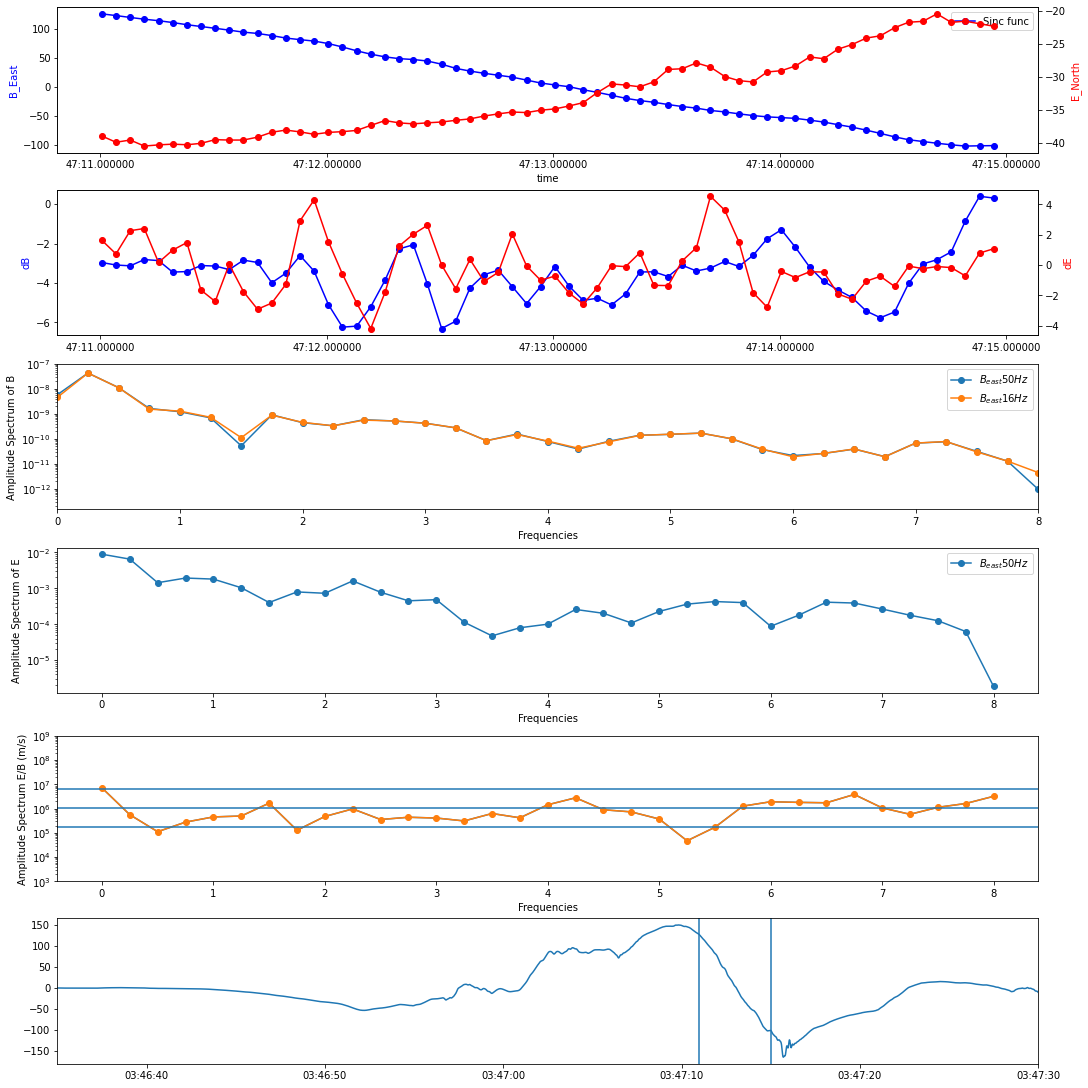

In [19]:
from scipy import interpolate

fig = plt.figure(figsize=(15, 15), constrained_layout=True)


gs = fig.add_gridspec(6, 1)


ax1 = fig.add_subplot(gs[0, 0])

ax5 = fig.add_subplot(gs[1, 0])

ax7 = fig.add_subplot(gs[2, 0])

ax9 = fig.add_subplot(gs[3, 0])

ax11= fig.add_subplot(gs[4, 0])

ax13= fig.add_subplot(gs[5, 0])
ax = [ax7, ax9, ax1, ax11, ax13, ax5]



sigma_p = 3


lat_list = lat_B


time_e = time_e_B


time_b = time_b_B


B_RES = B_RES_B


datelist = date_list_B


ElectricNEC = ElectricNEC_B


B_RES_resample = B_RES_resample_B

B_RES_sinc = B_RES_sinc_B


number = "B"



time_range = (datetime(2021,9,24,3,47,11), datetime(2021,9,24,3,47,15))

index_min_e = []

index_min_b = []

index_max_e = []

index_max_b = []

for k in range(len(time_e)):
    index_min_e.append(
        np.abs((time_range[0] - time_e[k]).total_seconds() / 60.0)
    )
    index_max_e.append(
        np.abs((time_range[1] - time_e[k]).total_seconds() / 60.0)
    )

for k in range(len(time_b)):

    index_min_b.append(
        np.abs((time_range[0] - time_b[k]).total_seconds() / 60.0)
    )
    index_max_b.append(
        np.abs((time_range[1] - time_b[k]).total_seconds() / 60.0)
    )

index_min_val_e = np.argmin(index_min_e)

index_min_val_b = np.argmin(index_min_b)

index_max_val_e = np.argmin(index_max_e)

index_max_val_b = np.argmin(index_max_b)

frequencies_50, powerspec_50 = signal.periodogram(
B_RES[range(index_min_val_b, index_max_val_b), 1],
50,
window="hann",detrend=False , scaling='spectrum'
)

ax[0].plot(
    frequencies_50, np.sqrt(powerspec_50),'-o', label=r"$B_{east} 50Hz$", 
)

frequencies_resample, powerspec_resample = signal.periodogram(
B_RES_resample[range(index_min_val_e, index_max_val_e), 1],
16,  window='hann',detrend=False , scaling='spectrum'
)
ax[0].plot(
    frequencies_resample, np.sqrt(powerspec_resample),'-o', label=r"$B_{east} 16Hz$"
)

frequencies_B_sinc, powerspec_B_sinc = signal.periodogram(
    B_RES_sinc[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)

#ax[0].plot(frequencies_B_sinc, np.sqrt(powerspec_B_sinc), '-o', label=r"$B_{east} 16 sincHz$")

ax[0].set_xlim(0, 8)



ax[0].legend()

ax[0].set_ylabel("Amplitude Spectrum of B")

ax[0].set_xlabel("Frequencies")
ax[0].set_yscale("log")
ax[0].set_ylim(1.5e-13, 1e-7)

frequencies_E, powerspec_E = signal.periodogram(
    ElectricNEC[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)
ax[1].plot(
    frequencies_E, np.sqrt(powerspec_E), '-o', label=r"$B_{east} 50Hz$"
)

ax[1].set_ylabel("Amplitude Spectrum of E")

ax[1].set_xlabel("Frequencies")

ax[1].legend()
ax[1].set_yscale("log")

"""
ax[2].scatter(
    time_e[range(index_min_val_e, index_max_val_e)],
    B_RES_resample[range(index_min_val_e, index_max_val_e), 1]*1e9,
    label="scipy",
)
"""
ax[2].plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    B_RES_sinc[range(index_min_val_e, index_max_val_e), 1]*1e9, "-o",
    label="Sinc func", color='blue'
)

ax[2].set_ylabel("B_East", color='blue')

ax[2].set_xlabel("time")



ax[2].legend()

ax22=ax[2].twinx()
ax22.plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    ElectricNEC[range(index_min_val_e, index_max_val_e), 0]*1e3,
    "-o", color='red', 
)
ax22.set_ylabel("E_North", color='red')



frequencies_per_E, powerspec_per_E = signal.periodogram(
    ElectricNEC[range(index_min_val_e, index_max_val_e), 0],
    16,
    window="hann",detrend=False , scaling='spectrum'
)
frequencies_per_B_scipy, powerspec_per_B_scipy = signal.periodogram(
    B_RES_resample[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)
ax[3].plot(
    frequencies_per_B_scipy,
    np.sqrt(powerspec_per_E/powerspec_per_B_scipy),
    label="E_N/B_E resample",
)
frequencies_per_sinc, powerspec_per_B_sinc = signal.periodogram(
    B_RES_sinc[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)

ax[3].plot(frequencies_per_sinc, np.sqrt(powerspec_per_E/powerspec_per_B_scipy),'-o', label="E_N/B_E Fourier Transform")
ax[3].axhline(y=np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0])
ax[3].axhline(y=np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))
ax[3].set_yscale("log")
ax[3].set_ylim(1e3, 1e9)

ax[3].axhline(y=(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))**2*np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]*mu0)

ax[3].axhline(y=(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))**2* 1/(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]*mu0)*mu0)
print(1/(1.256e-6*np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]))
print(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))

ax[3].set_ylabel("Amplitude Spectrum E/B (m/s)")

ax[3].set_xlabel("Frequencies")
##ax[4].set_yscale("symlog")
ax[4].plot(time_b, B_RES[:,1]*1e9)
ax[4].axvline(time_range[0])
ax[4].axvline(time_range[1])

ax[5].plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    np.gradient(B_RES_sinc[range(index_min_val_e, index_max_val_e), 1]*1e9),  "-o",
    label="Sinc func", color='blue'
)
ax[5].set_ylabel("dB", color='blue')
ax5=ax[5].twinx()
ax5.plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    np.gradient(ElectricNEC[range(index_min_val_e, index_max_val_e), 1]*1e3), "-o",
    label="Electric field", color='red'
)
ax5.set_ylabel("dE", color='red')


ax[4].set_xlim((datetime(2021,9,24,3,46,35), datetime(2021,9,24,3,47,30)))

2.284478154184391
7998170.726659372


(18894.157349537036, 18894.15798611111)

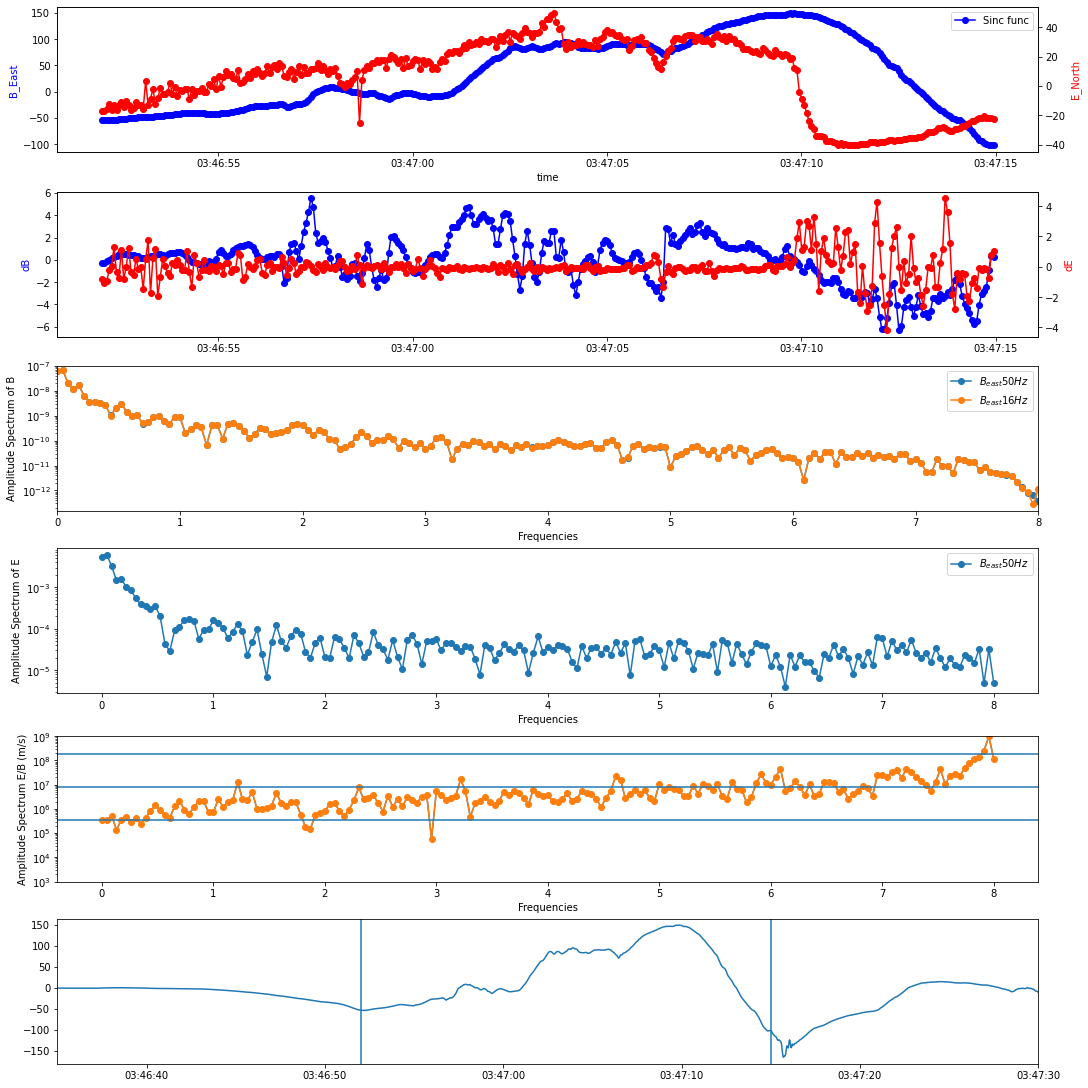

In [20]:
from scipy import interpolate

fig = plt.figure(figsize=(15, 15), constrained_layout=True)


gs = fig.add_gridspec(6, 1)


ax1 = fig.add_subplot(gs[0, 0])

ax5 = fig.add_subplot(gs[1, 0])

ax7 = fig.add_subplot(gs[2, 0])

ax9 = fig.add_subplot(gs[3, 0])

ax11= fig.add_subplot(gs[4, 0])

ax13= fig.add_subplot(gs[5, 0])
ax = [ax7, ax9, ax1, ax11, ax13, ax5]



sigma_p = 3


lat_list = lat_B


time_e = time_e_B


time_b = time_b_B


B_RES = B_RES_B


datelist = date_list_B


ElectricNEC = ElectricNEC_B


B_RES_resample = B_RES_resample_B

B_RES_sinc = B_RES_sinc_B


number = "B"



time_range = (datetime(2021,9,24,3,46,52), datetime(2021,9,24,3,47,15))

index_min_e = []

index_min_b = []

index_max_e = []

index_max_b = []

for k in range(len(time_e)):
    index_min_e.append(
        np.abs((time_range[0] - time_e[k]).total_seconds() / 60.0)
    )
    index_max_e.append(
        np.abs((time_range[1] - time_e[k]).total_seconds() / 60.0)
    )

for k in range(len(time_b)):

    index_min_b.append(
        np.abs((time_range[0] - time_b[k]).total_seconds() / 60.0)
    )
    index_max_b.append(
        np.abs((time_range[1] - time_b[k]).total_seconds() / 60.0)
    )

index_min_val_e = np.argmin(index_min_e)

index_min_val_b = np.argmin(index_min_b)

index_max_val_e = np.argmin(index_max_e)

index_max_val_b = np.argmin(index_max_b)

frequencies_50, powerspec_50 = signal.periodogram(
B_RES[range(index_min_val_b, index_max_val_b), 1],
50,
window="hann",detrend=False , scaling='spectrum'
)

ax[0].plot(
    frequencies_50, np.sqrt(powerspec_50),'-o', label=r"$B_{east} 50Hz$", 
)

frequencies_resample, powerspec_resample = signal.periodogram(
B_RES_resample[range(index_min_val_e, index_max_val_e), 1],
16,  window='hann',detrend=False , scaling='spectrum'
)
ax[0].plot(
    frequencies_resample, np.sqrt(powerspec_resample),'-o', label=r"$B_{east} 16Hz$"
)

frequencies_B_sinc, powerspec_B_sinc = signal.periodogram(
    B_RES_sinc[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)

#ax[0].plot(frequencies_B_sinc, np.sqrt(powerspec_B_sinc), '-o', label=r"$B_{east} 16 sincHz$")

ax[0].set_xlim(0, 8)



ax[0].legend()

ax[0].set_ylabel("Amplitude Spectrum of B")

ax[0].set_xlabel("Frequencies")
ax[0].set_yscale("log")
ax[0].set_ylim(1.5e-13, 1e-7)

frequencies_E, powerspec_E = signal.periodogram(
    ElectricNEC[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)
ax[1].plot(
    frequencies_E, np.sqrt(powerspec_E), '-o', label=r"$B_{east} 50Hz$"
)

ax[1].set_ylabel("Amplitude Spectrum of E")

ax[1].set_xlabel("Frequencies")

ax[1].legend()
ax[1].set_yscale("log")

"""
ax[2].scatter(
    time_e[range(index_min_val_e, index_max_val_e)],
    B_RES_resample[range(index_min_val_e, index_max_val_e), 1]*1e9,
    label="scipy",
)
"""
ax[2].plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    B_RES_sinc[range(index_min_val_e, index_max_val_e), 1]*1e9, "-o",
    label="Sinc func", color='blue'
)

ax[2].set_ylabel("B_East", color='blue')

ax[2].set_xlabel("time")



ax[2].legend()

ax22=ax[2].twinx()
ax22.plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    ElectricNEC[range(index_min_val_e, index_max_val_e), 0]*1e3,
    "-o", color='red', 
)
ax22.set_ylabel("E_North", color='red')



frequencies_per_E, powerspec_per_E = signal.periodogram(
    ElectricNEC[range(index_min_val_e, index_max_val_e), 0],
    16,
    window="hann",detrend=False , scaling='spectrum'
)
frequencies_per_B_scipy, powerspec_per_B_scipy = signal.periodogram(
    B_RES_resample[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)
ax[3].plot(
    frequencies_per_B_scipy,
    np.sqrt(powerspec_per_E/powerspec_per_B_scipy),
    label="E_N/B_E resample",
)
frequencies_per_sinc, powerspec_per_B_sinc = signal.periodogram(
    B_RES_sinc[range(index_min_val_e, index_max_val_e), 1],
    16,
    window="hann",detrend=False , scaling='spectrum'
)

ax[3].plot(frequencies_per_sinc, np.sqrt(powerspec_per_E/powerspec_per_B_scipy),'-o', label="E_N/B_E Fourier Transform")
ax[3].axhline(y=np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0])
ax[3].axhline(y=np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))
ax[3].set_yscale("log")
ax[3].set_ylim(1e3, 1e9)

ax[3].axhline(y=(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))**2*np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]*mu0)

ax[3].axhline(y=(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))**2* 1/(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]*mu0)*mu0)


ax[3].set_ylabel("Amplitude Spectrum E/B (m/s)")

ax[3].set_xlabel("Frequencies")
##ax[4].set_yscale("symlog")
ax[4].plot(time_b, B_RES[:,1]*1e9)
ax[4].axvline(time_range[0])
ax[4].axvline(time_range[1])

ax[5].plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    np.gradient(B_RES_sinc[range(index_min_val_e, index_max_val_e), 1]*1e9),  "-o",
    label="Sinc func", color='blue'
)
ax[5].set_ylabel("dB", color='blue')
ax5=ax[5].twinx()
ax5.plot(
    time_e[range(index_min_val_e, index_max_val_e)],
    np.gradient(ElectricNEC[range(index_min_val_e, index_max_val_e), 1]*1e3), "-o",
    label="Electric field", color='red'
)
ax5.set_ylabel("dE", color='red')
print(1/(1.256e-6*np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]))
print(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))

ax[4].set_xlim((datetime(2021,9,24,3,46,35), datetime(2021,9,24,3,47,30)))

In [21]:
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN
fig = plt.figure(figsize=(15, 15), constrained_layout=True)
base = datetime(2021,9, 24, 3, 46)
datelist = [base + timedelta(seconds=0.1*x) for x in range(1320)]

gs = fig.add_gridspec(6, 1)


ax1 = fig.add_subplot(gs[0, 0])

ax5 = fig.add_subplot(gs[1, 0])

ax7 = fig.add_subplot(gs[2, 0])

ax9 = fig.add_subplot(gs[3, 0])

ax11= fig.add_subplot(gs[4, 0])

ax13= fig.add_subplot(gs[5, 0])
ax = [ax7, ax9, ax1, ax11, ax13, ax5]
ax22=ax[2].twinx()
ax55=ax[5].twinx()
sigmas=[]
times=[]
speed=[]
def update(i):
    ax1.clear()

    ax5.clear()

    ax7.clear()

    ax9.clear()
    
    ax11.clear()
    
    ax13.clear()
    ax22.clear()
    ax55.clear()


    time_range = (datelist[i], datelist[i + 50])

    index_min_e = []

    index_min_b = []

    index_max_e = []

    index_max_b = []

    for k in range(len(time_e)):
        index_min_e.append(
            np.abs((time_range[0] - time_e[k]).total_seconds() / 60.0)
        )
        index_max_e.append(
            np.abs((time_range[1] - time_e[k]).total_seconds() / 60.0)
        )

    for k in range(len(time_b)):

        index_min_b.append(
            np.abs((time_range[0] - time_b[k]).total_seconds() / 60.0)
        )
        index_max_b.append(
            np.abs((time_range[1] - time_b[k]).total_seconds() / 60.0)
        )

    index_min_val_e = np.argmin(index_min_e)

    index_min_val_b = np.argmin(index_min_b)

    index_max_val_e = np.argmin(index_max_e)

    index_max_val_b = np.argmin(index_max_b)

    frequencies_50, powerspec_50 = signal.periodogram(
    B_RES[range(index_min_val_b, index_max_val_b), 1],
    50,
    window="hann",detrend=False , scaling='spectrum'
    )

    ax[0].plot(
        frequencies_50, np.sqrt(powerspec_50),'-o', label=r"$B_{east} 50Hz$", 
    )

    frequencies_resample, powerspec_resample = signal.periodogram(
    B_RES_resample[range(index_min_val_e, index_max_val_e), 1],
    16,  window='hann',detrend=False , scaling='spectrum'
    )
    ax[0].plot(
        frequencies_resample, np.sqrt(powerspec_resample),'-o', label=r"$B_{east} 16Hz$"
    )

    frequencies_B_sinc, powerspec_B_sinc = signal.periodogram(
        B_RES_sinc[range(index_min_val_e, index_max_val_e), 1],
        16,
        window="hann",detrend=False , scaling='spectrum'
    )

    ax[0].plot(frequencies_B_sinc, np.sqrt(powerspec_B_sinc), '-o', label=r"$B_{east} 16 sincHz$")

    ax[0].set_xlim(0, 8)

    

    ax[0].legend()

    ax[0].set_ylabel("Amplitude Spectrum of B")

    ax[0].set_xlabel("Frequencies")
    ax[0].set_yscale("log")
    ax[0].set_ylim(1.5e-13, 1e-7)

    frequencies_E, powerspec_E = signal.periodogram(
        ElectricNEC[range(index_min_val_e, index_max_val_e), 1],
        16,
        window="hann",detrend=False , scaling='spectrum'
    )
    ax[1].plot(
        frequencies_E, np.sqrt(powerspec_E), '-o', label=r"$B_{east} 50Hz$"
    )

    ax[1].set_ylabel("Amplitude Spectrum of E")

    ax[1].set_xlabel("Frequencies")

    ax[1].legend()
    ax[1].set_yscale("log")

    ax[2].plot(
        time_b[range(index_min_val_b, index_max_val_b)],
        B_RES[range(index_min_val_b, index_max_val_b), 1]*1e9,
        label="50Hz",
    )

    ax[2].scatter(
        time_e[range(index_min_val_e, index_max_val_e)],
        B_RES_resample[range(index_min_val_e, index_max_val_e), 1]*1e9,
        label="scipy",
    )
    ax[2].scatter(
        time_e[range(index_min_val_e, index_max_val_e)],
        B_RES_sinc[range(index_min_val_e, index_max_val_e), 1]*1e9,
        label="Sinc func",
    )

    ax[2].set_ylabel("B_East")

    ax[2].set_xlabel("time")

    

    ax[2].legend()

    ax22.plot(
        time_e[range(index_min_val_e, index_max_val_e)],
        ElectricNEC[range(index_min_val_e, index_max_val_e), 0]*1e3,
        "-o",
    )



    frequencies_per_E, powerspec_per_E = signal.periodogram(
        ElectricNEC[range(index_min_val_e, index_max_val_e), 0],
        16,
        window="hann",detrend=False , scaling='spectrum'
    )
    frequencies_per_B_scipy, powerspec_per_B_scipy = signal.periodogram(
        B_RES_resample[range(index_min_val_e, index_max_val_e), 1],
        16,
        window="hann",detrend=False , scaling='spectrum'
    )
    ax[3].plot(
        frequencies_per_B_scipy,
        np.sqrt(powerspec_per_E/powerspec_per_B_scipy),
        label="E_N/B_E resample",
    )
    frequencies_per_sinc, powerspec_per_B_sinc = signal.periodogram(
        B_RES_sinc[range(index_min_val_e, index_max_val_e), 1],
        16,
        window="hann",detrend=False , scaling='spectrum'
    )

    ax[3].plot(frequencies_per_sinc, np.sqrt(powerspec_per_E/powerspec_per_B_sinc),'-o', label="E_N/B_E scipy")
    ax[3].axhline(y=np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0])
    ax[3].axhline(y=np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))
    ax[3].set_yscale("log")
    ax[3].set_ylim(1e3, 1.2e8)

    ax[3].axhline(y=(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))**2*np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]*mu0)

    ax[3].axhline(y=(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))**2* 1/(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]*mu0)*mu0)
    sigmas.append(1/(1.256e-6*np.sqrt(powerspec_per_E/powerspec_per_B_sinc)[0]))
    speed.append(np.mean(np.sqrt(powerspec_per_E/powerspec_per_B_sinc)))
    times.append(datelist[i]+timedelta(seconds=2.5))

    ax[3].set_ylabel("Amplitude Spectrum")

    ax[3].set_xlabel("Frequencies")
    ##ax[4].set_yscale("symlog")
    ax[4].plot(time_b, B_RES[:,1]*1e9)
    ax[4].axvline(time_range[0])
    ax[4].axvline(time_range[1])

    ax[5].plot(
        time_e[range(index_min_val_e, index_max_val_e)],
        np.gradient(B_RES_resample[range(index_min_val_e, index_max_val_e), 1]*1e9),
        label="scipy",
    )
    ax[5].plot(
        time_e[range(index_min_val_e, index_max_val_e)],
        np.gradient(B_RES_sinc[range(index_min_val_e, index_max_val_e), 1]*1e9),
        label="Sinc func",
    )
    ax[5].set_ylabel("dB")
    ax5.plot(
        time_e[range(index_min_val_e, index_max_val_e)],
        np.gradient(ElectricNEC[range(index_min_val_e, index_max_val_e), 1]*1e3),
        label="Sinc func",
    )


        ##ax[5].set_xlim((datetime(2021,9,24,3,46,35), datetime(2021,9,24,3,47,30)))

ani = animation.FuncAnimation(fig=fig, func=update, frames=1250, interval=300)
from matplotlib.animation import PillowWriter
writer = PillowWriter(fps=10)
ani.save("goodeventwithBnodetrend.gif", writer=writer)



[datetime.datetime(2021, 9, 24, 3, 46, 2, 900000)
 datetime.datetime(2021, 9, 24, 3, 46, 3)
 datetime.datetime(2021, 9, 24, 3, 46, 3, 100000) ...
 datetime.datetime(2021, 9, 24, 3, 48, 6, 800000)
 datetime.datetime(2021, 9, 24, 3, 48, 6, 900000)
 datetime.datetime(2021, 9, 24, 3, 48, 7)]
[0.05189492 0.03545997 0.02826163 ... 0.74938219 0.74899165 0.75930493]
7050 7048


Text(0.5, 1.0, 'Overplot of Conductivity and the Magnetic Field')

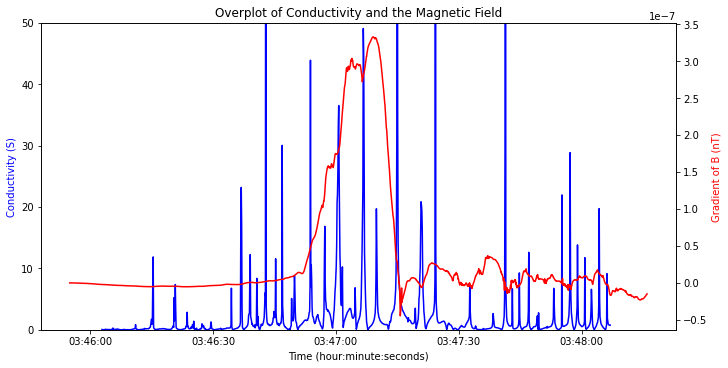

In [ ]:
fig,ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax2=ax.twinx()
times=np.delete(times,[0,-1])
sigmas=np.delete(sigmas,[0,-1])
ax.plot(times,sigmas ,color='blue')
ax.set_ylim(0,50)
print(times)
print(sigmas)
ax2.plot(time_b,B_not_averaged, color='red',)
print(len(time_b), len(np.diff(B_RES_B[:,1],2)))
ax.set_xlabel("Time (hour:minute:seconds)")
ax.set_ylabel("Conductivity (S)", color='blue')
ax2.set_ylabel("Gradient of B (nT)", color='red')
plt.title("Overplot of Conductivity and the Magnetic Field")


ValueError: x and y must have same first dimension, but have shapes (1242,) and (1252,)

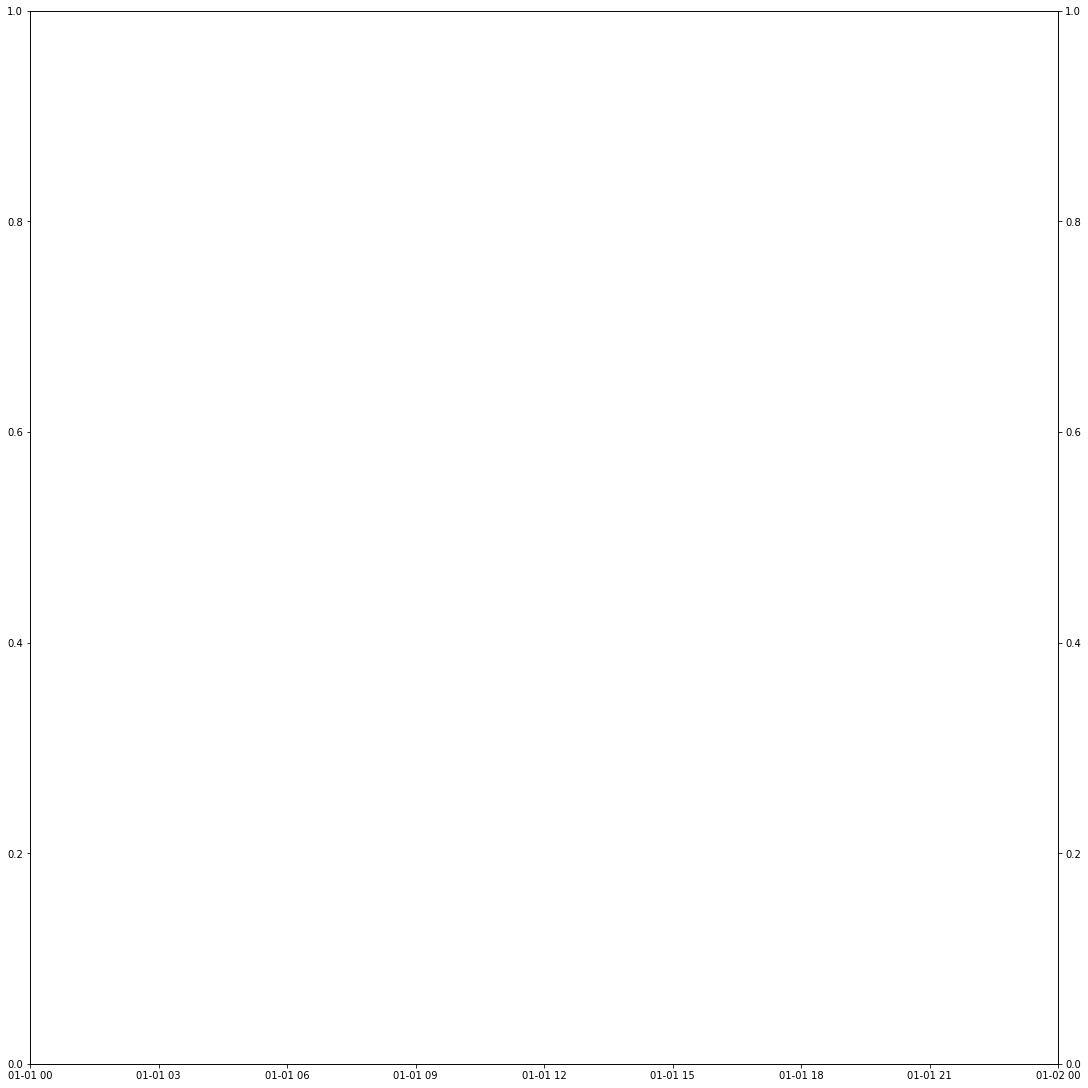

In [ ]:
fig,ax = plt.subplots(figsize=(15, 15), constrained_layout=True)
ax2=ax.twinx()
ax.plot(times,speed)
ax.set_yscale("log")
ax2.plot(time_b,B_RES_B[:,1], color='red')